In [1]:

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [14]:
# =============================================================================
# Colab Notebook 使用示例
# =============================================================================

# Cell 1: 安装和导入必要的库
# !pip install scikit-learn scipy seaborn

import json
import re
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
from sklearn.metrics.pairwise import cosine_similarity
from scipy.signal import find_peaks
from typing import Dict, List, Tuple, Any

# # 挂载Google Drive
# from google.colab import drive
# drive.mount('/content/drive')

# =============================================================================
# Cell 2: 定义数据加载器类
# =============================================================================

class DataLoader:
    """
    数据加载器类，用于加载和缓存数据
    """

    def __init__(self):
        self.error_fix_data = None
        self.original_data = None
        self.data_loaded = False
        self.paths = {}

    def setup_paths(self, start_index: int = 700, end_index: int = 731,
                   base_path: str = "/content/drive/MyDrive/Cluster-proj"):
        """设置数据路径"""
        range_tag = f"{start_index}-{end_index}"

        self.paths = {
            'range_tag': range_tag,
            'base_path': base_path,
            'logits_path': f"{base_path}/output/llm_steps/whole_logits/deepseek7b-gsm-{range_tag}-hidden.json",
            'error_index_path': f"{base_path}/output/error_fix_index/deepseek-7b-{range_tag}_error_fix_index.json",
            'save_path': f"{base_path}/output/step_inspect"
        }

        os.makedirs(self.paths['save_path'], exist_ok=True)

        print(f"📁 Paths configured:")
        print(f"  - Range: {range_tag}")
        print(f"  - Logits path: {self.paths['logits_path']}")
        print(f"  - Error index path: {self.paths['error_index_path']}")
        print(f"  - Save path: {self.paths['save_path']}")

    def load_data(self, force_reload: bool = False):
        """加载数据"""
        if self.data_loaded and not force_reload:
            print("📊 Using cached data")
            return self.error_fix_data, self.original_data

        print("📥 Loading data...")

        # 加载数据
        print("  📖 Loading logits data...")
        with open(self.paths['logits_path'], 'r', encoding='utf-8') as f:
            self.original_data = json.load(f)

        print("  📖 Loading error index data...")
        with open(self.paths['error_index_path'], 'r', encoding='utf-8') as f:
            self.error_fix_data = json.load(f)

        self.data_loaded = True

        print(f"✅ Data loaded successfully!")
        print(f"  - Original data samples: {len(self.original_data)}")
        print(f"  - Error fix data samples: {len(self.error_fix_data)}")

        return self.error_fix_data, self.original_data

    def get_paths(self):
        """获取配置的路径"""
        return self.paths.copy()

    def get_sample_preview(self, qid: str = None, max_tokens: int = 3):
        """获取样本预览"""
        if not self.data_loaded:
            return {"error": "Data not loaded"}

        if qid is None:
            qid = list(self.original_data.keys())[0]

        sample = self.original_data[qid]
        preview = {
            "qid": qid,
            "question": sample.get('question', 'N/A')[:150] + "...",
            "samplings": {}
        }

        for key, value in sample.items():
            if key.startswith('sampling'):
                preview["samplings"][key] = {
                    "whole_answer": value.get('whole_answer', 'N/A')[:100] + "...",
                    "token_count": len(value.get('token_probs', [])),
                    "first_tokens": [t.get('token', 'N/A') for t in value.get('token_probs', [])[:max_tokens]]
                }

        return preview



In [15]:
# =============================================================================
# Cell 3: 一次性加载数据（这个cell只运行一次）
# =============================================================================

# 创建数据加载器实例
loader = DataLoader()

# 设置路径
loader.setup_paths(start_index=700, end_index=731)

# 加载数据
error_fix_data, original_data = loader.load_data()
paths = loader.get_paths()

# 预览数据
preview = loader.get_sample_preview()
print("\n📋 Sample preview:")
print(json.dumps(preview, indent=2, ensure_ascii=False)[:500] + "...")

print(f"\n🎉 Data loaded and ready to use!")
print(f"📊 Available samples: {len(error_fix_data)}")


📁 Paths configured:
  - Range: 700-731
  - Logits path: /content/drive/MyDrive/Cluster-proj/output/llm_steps/whole_logits/deepseek7b-gsm-700-731-hidden.json
  - Error index path: /content/drive/MyDrive/Cluster-proj/output/error_fix_index/deepseek-7b-700-731_error_fix_index.json
  - Save path: /content/drive/MyDrive/Cluster-proj/output/step_inspect
📥 Loading data...
  📖 Loading logits data...
  📖 Loading error index data...
✅ Data loaded successfully!
  - Original data samples: 31
  - Error fix data samples: 19

📋 Sample preview:
{
  "qid": "q_700",
  "question": "Two white socks cost 25 cents more than a single brown sock. If two white socks cost 45 cents, how much would you pay for 15 brown socks?...",
  "samplings": {
    "sampling0": {
      "whole_answer": "Two white socks cost 25 cents more than a single brown sock.\nTwo white socks cost 45 cents.\n\n<steps>...",
      "token_count": 305,
      "first_tokens": [
        "Two",
        "white",
        "socks"
      ]
    },
    "s

📊 StepTokenMapper initialized with:
  - Error fix data: 19 samples
  - Original data: 31 samples
📊 Available question IDs: 19
📋 First 5 QIDs: ['q_700', 'q_701', 'q_703', 'q_705', 'q_707']

🔍 Testing with sample: q_700
🔍 Processing sample q_700
  📝 Processing negative sample: sampling0
  🔍 Computing step boundaries for q_700_sampling0
  ✅ Cached 11 steps for q_700_sampling0
  📝 Processing negative sample: sampling2
  🔍 Computing step boundaries for q_700_sampling2
  ✅ Cached 10 steps for q_700_sampling2
  📝 Processing positive sample: sampling1
  🔍 Computing step boundaries for q_700_sampling1
  ✅ Cached 7 steps for q_700_sampling1
✅ Completed processing q_700
✅ Successfully processed q_700
📊 Available samplings: ['sampling0', 'sampling2', 'sampling1']
📋 Sample type: negative
📋 Steps count: 11
📋 Tokens count: 305
📊 Cache Info:
  - Cached samples: 3
  - q_700_sampling0: 11 steps, 305 tokens
  - q_700_sampling2: 10 steps, 275 tokens
  - q_700_sampling1: 7 steps, 143 tokens
🎯 Analyzing sam

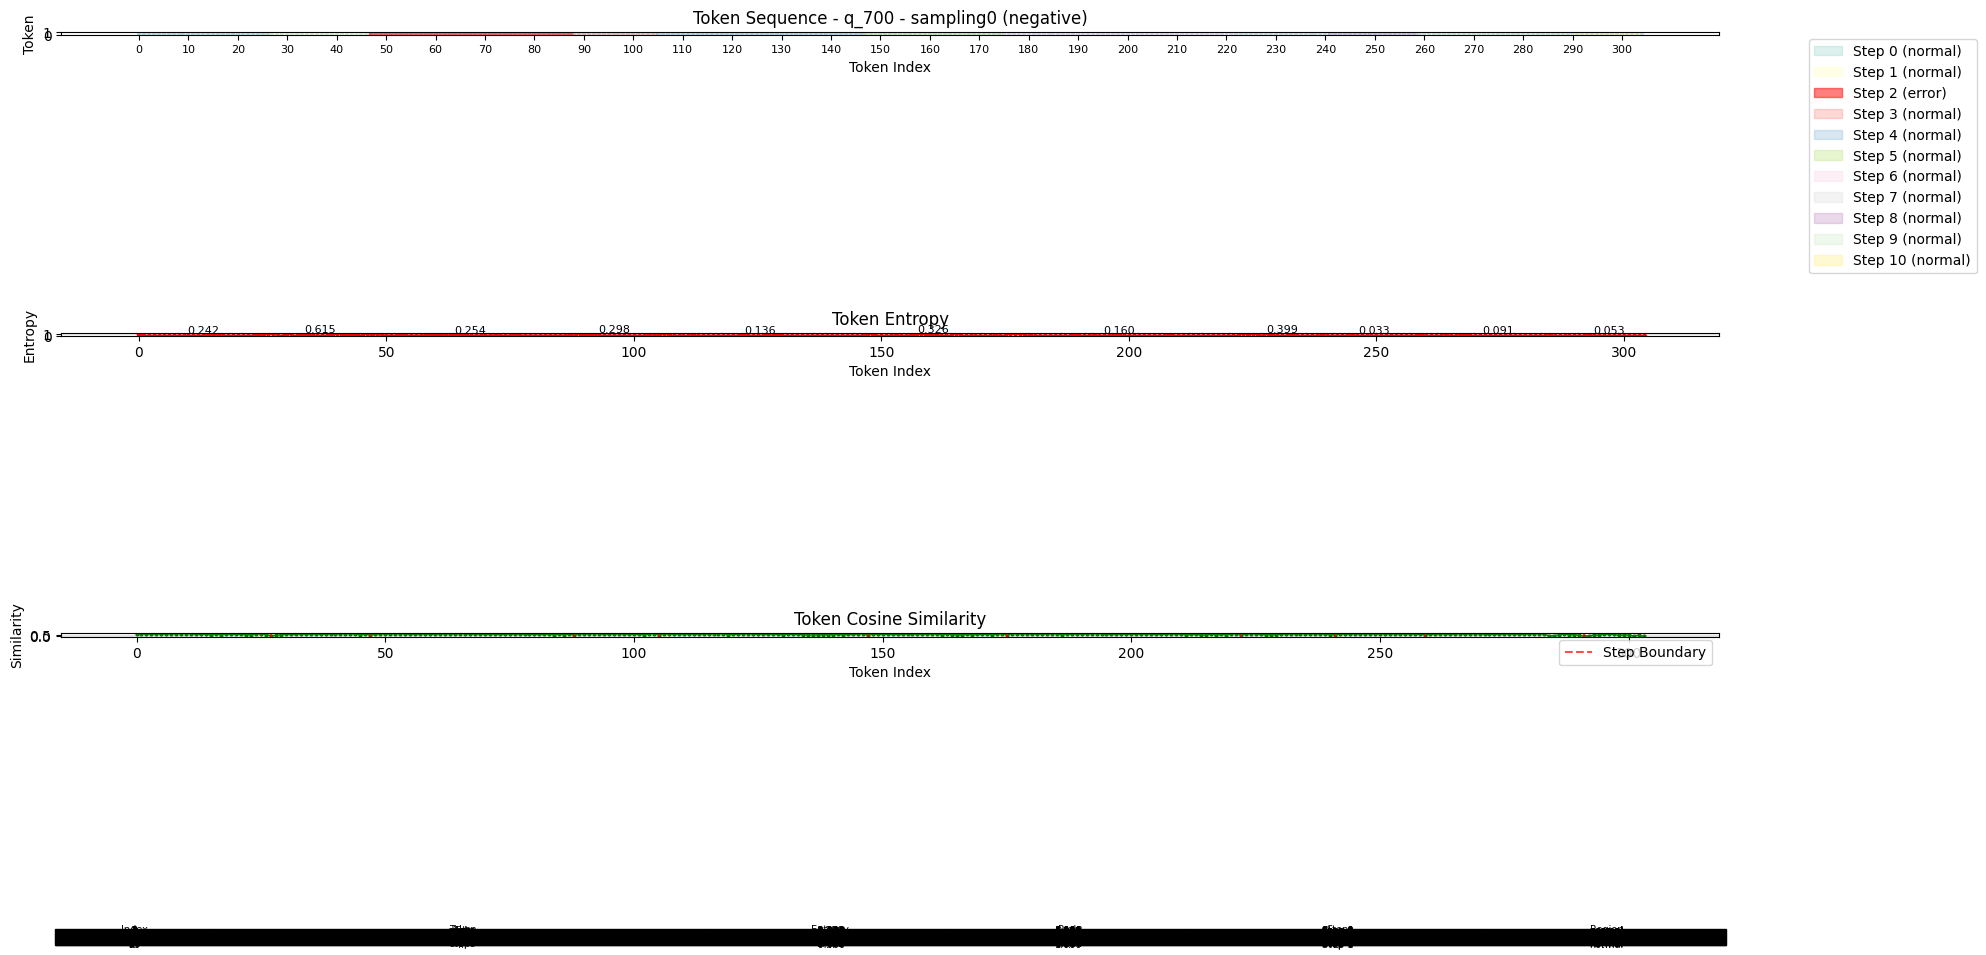


📊 STEP ANALYSIS: q_700 - sampling0
📋 Sample Type: negative
📋 Total Steps: 11
📋 Total Tokens: 305
Step 0: Token 0--26
  Content: Two white socks cost  2 5 cents more than a single brown sock .  Two white socks cost  4 5 cents .  
  Average Entropy: 0.242
  Token Count: 27

Step 1: Token 27--46
  Content: < steps > 2 5 cents of the  4 5 cents cost increase is for the brown sock .
  Average Entropy: 0.615
  Token Count: 20

Step 2: Token 47--87 🔴 ERROR
  Content:  To find the cost of a single brown sock , divide the  4 5 cents cost of two white socks by  2 :  4 5 cents /  2 =  2 2 . 5 cents .
  Average Entropy: 0.254
  Token Count: 41

Step 3: Token 88--104
  Content:  The cost of a single brown sock is  2 2 . 5 cents . 
  Average Entropy: 0.298
  Token Count: 17

Step 4: Token 105--146
  Content:  Since two white socks cost  2 5 cents more than a single brown sock , a single white sock costs  2 2 . 5 cents +  2 5 cents =  4 7 . 5 cents . 
  Average Entropy: 0.136
  Token Count: 42

Step

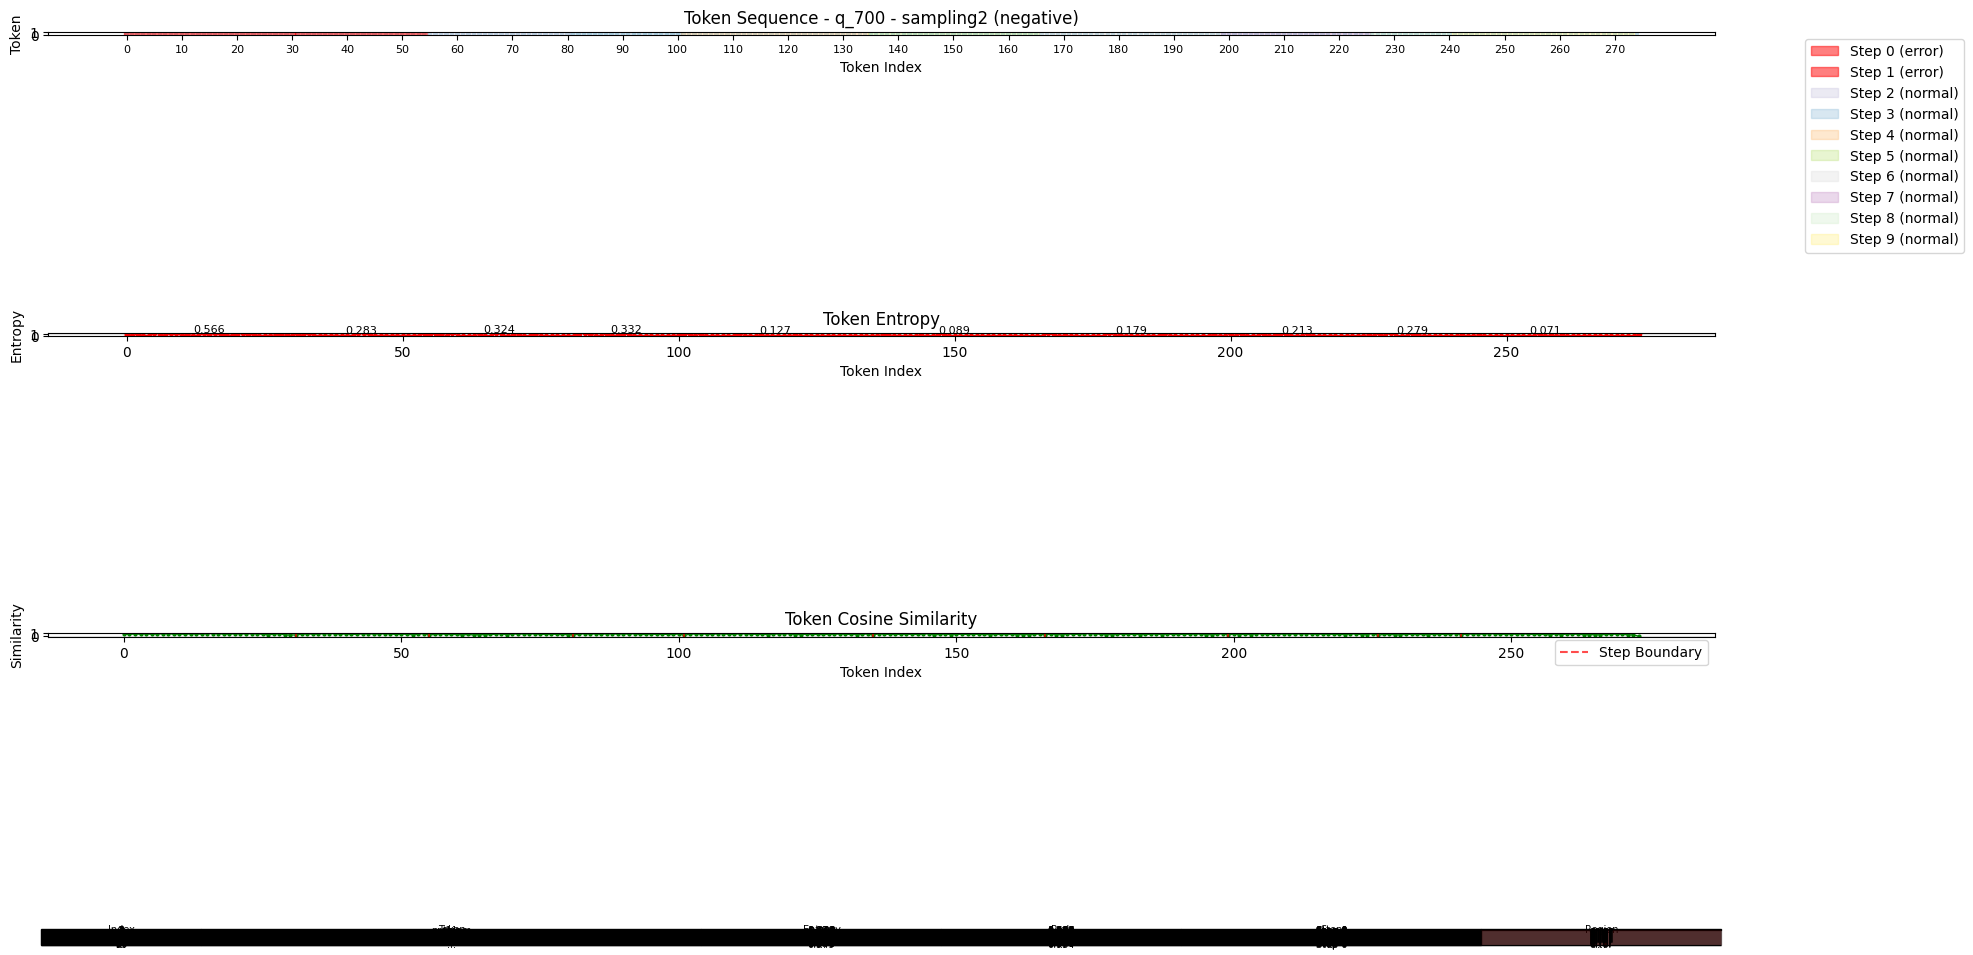


📊 STEP ANALYSIS: q_700 - sampling2
📋 Sample Type: negative
📋 Total Steps: 10
📋 Total Tokens: 275
Step 0: Token 0--30 🔴 ERROR
  Content: In this problem , we can set up a simple equation to represent the cost of a single brown sock and the cost of two white socks .   Let
  Average Entropy: 0.566
  Token Count: 31

Step 1: Token 31--54 🔴 ERROR
  Content: ' s denote the cost of a single brown sock as B , and the cost of two white socks as W . 
  Average Entropy: 0.283
  Token Count: 24

Step 2: Token 55--80
  Content:  We know that W = B +  2 5 cents .   We also know that two white socks cost  4 5
  Average Entropy: 0.324
  Token Count: 26

Step 3: Token 81--100
  Content: cents . So , we can set up the equation :   W =  4 5 cents 
  Average Entropy: 0.332
  Token Count: 20

Step 4: Token 101--134
  Content:  Substituting the value of W from the first equation into the second equation , we get :   ( B +  2 5 cents ) =  4 5 cents 
  Average Entropy: 0.127
  Token Count: 34

Step 5: Token 

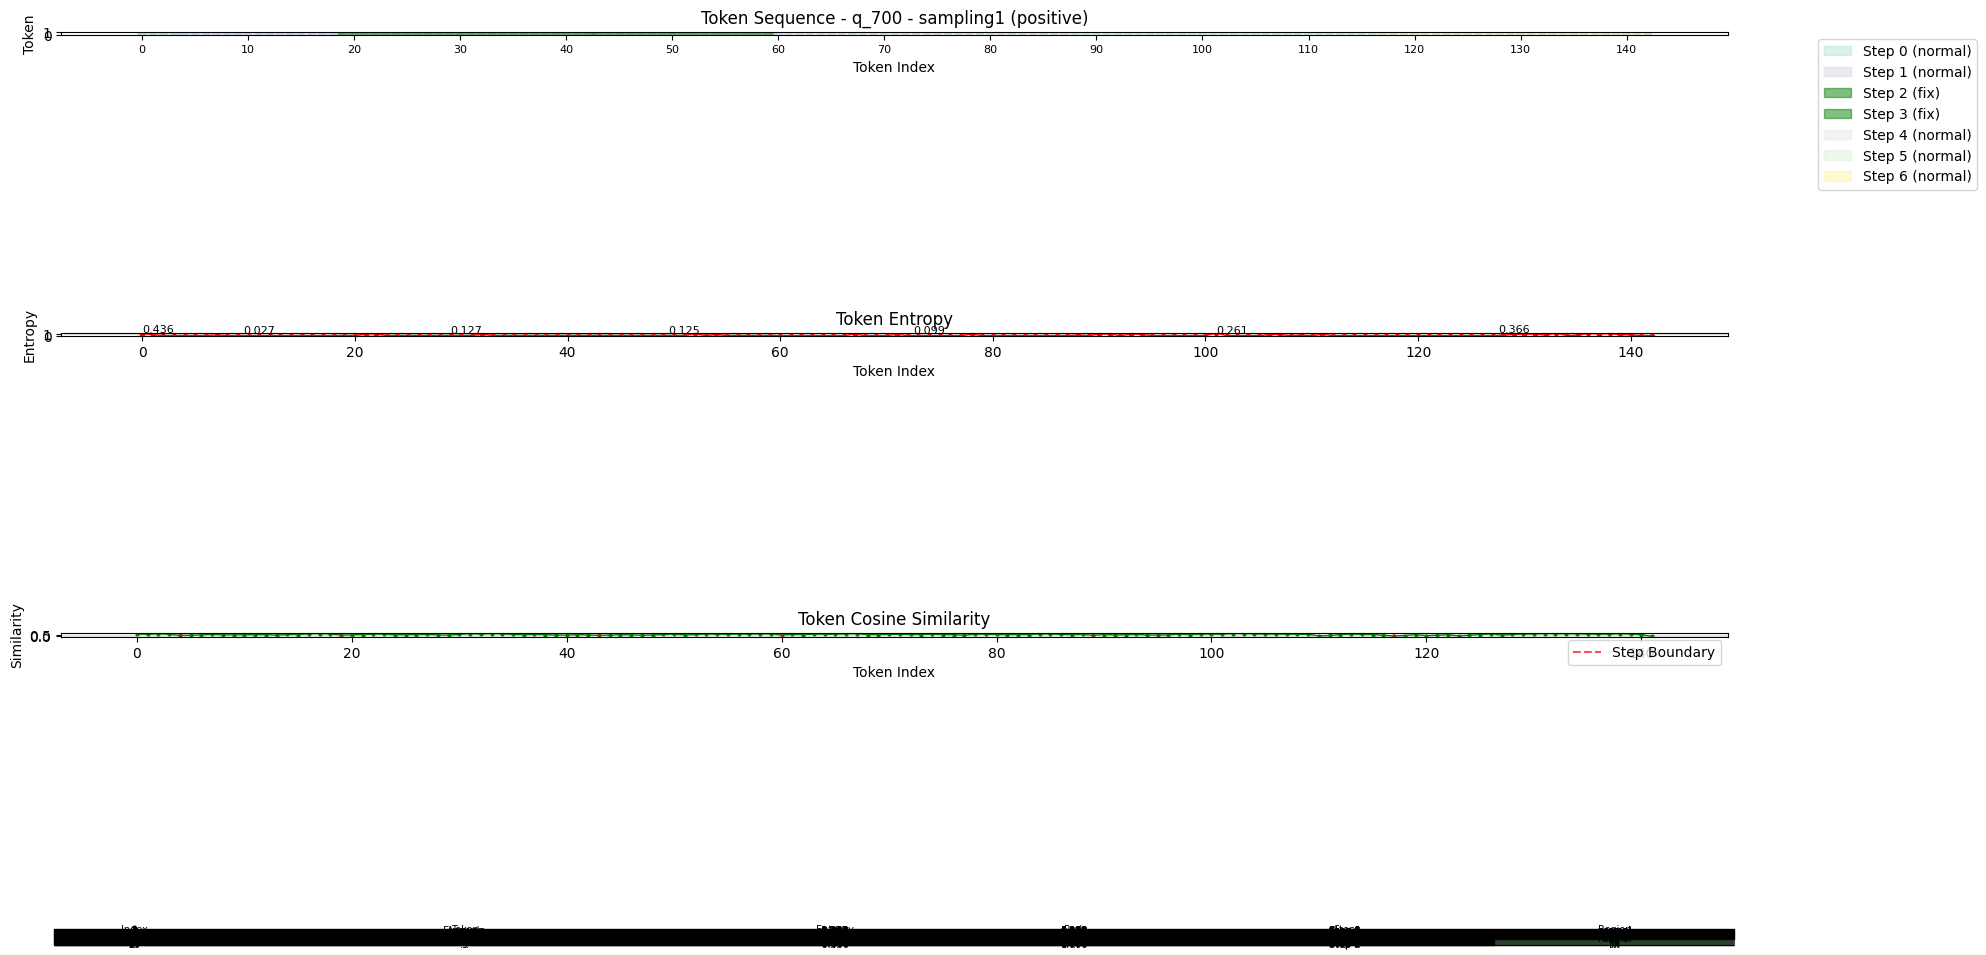


📊 STEP ANALYSIS: q_700 - sampling1
📋 Sample Type: positive
📋 Total Steps: 7
📋 Total Tokens: 143
Step 0: Token 0--3
  Content: Example Answer : 
  Average Entropy: 0.436
  Token Count: 4
  Token Details:
    [0] 'Example' (entropy: 1.158)
    [1] 'Answer' (entropy: 0.587)
    [2] ':' (entropy: -0.000)
    [3] '' (entropy: -0.000)

Step 1: Token 4--18
  Content: < steps > Two white socks cost  2 5 cents more than a single
  Average Entropy: 0.027
  Token Count: 15

Step 2: Token 19--42 🟢 FIX
  Content: brown sock . If two white socks cost  4 5 cents , then a single brown sock costs  4 5 - 
  Average Entropy: 0.127
  Token Count: 24

Step 3: Token 43--59 🟢 FIX
  Content: 2 5 =  2 0 cents .  To find the cost of  1 5
  Average Entropy: 0.125
  Token Count: 17

Step 4: Token 60--88
  Content: brown socks , multiply the cost of one brown sock by  1 5 :  2 0 *  1 5 =  3 0 0 cents .
  Average Entropy: 0.099
  Token Count: 29

Step 5: Token 89--116
  Content:  Since  1 dollar equals  1 0 0 cent

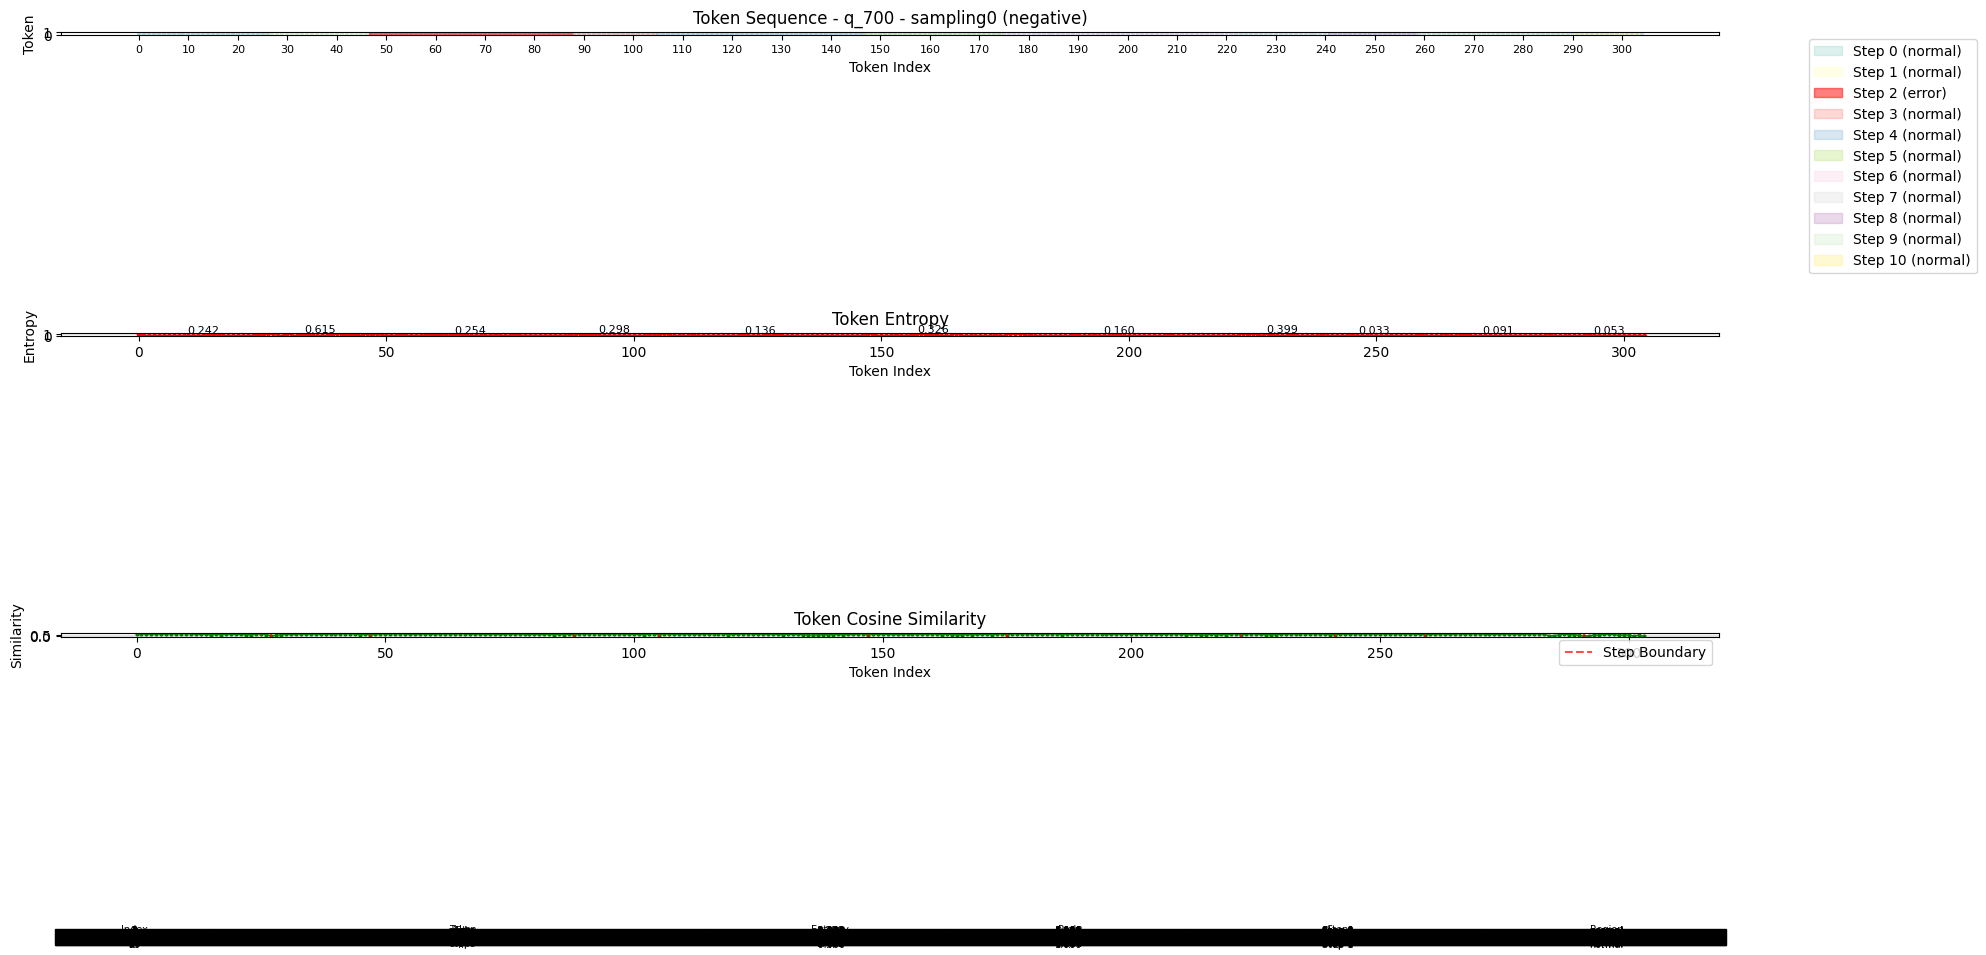


📊 STEP ANALYSIS: q_700 - sampling0
📋 Sample Type: negative
📋 Total Steps: 11
📋 Total Tokens: 305
Step 0: Token 0--26
  Content: Two white socks cost  2 5 cents more than a single brown sock .  Two white socks cost  4 5 cents .  
  Average Entropy: 0.242
  Token Count: 27

Step 1: Token 27--46
  Content: < steps > 2 5 cents of the  4 5 cents cost increase is for the brown sock .
  Average Entropy: 0.615
  Token Count: 20

Step 2: Token 47--87 🔴 ERROR
  Content:  To find the cost of a single brown sock , divide the  4 5 cents cost of two white socks by  2 :  4 5 cents /  2 =  2 2 . 5 cents .
  Average Entropy: 0.254
  Token Count: 41

Step 3: Token 88--104
  Content:  The cost of a single brown sock is  2 2 . 5 cents . 
  Average Entropy: 0.298
  Token Count: 17

Step 4: Token 105--146
  Content:  Since two white socks cost  2 5 cents more than a single brown sock , a single white sock costs  2 2 . 5 cents +  2 5 cents =  4 7 . 5 cents . 
  Average Entropy: 0.136
  Token Count: 42

Step

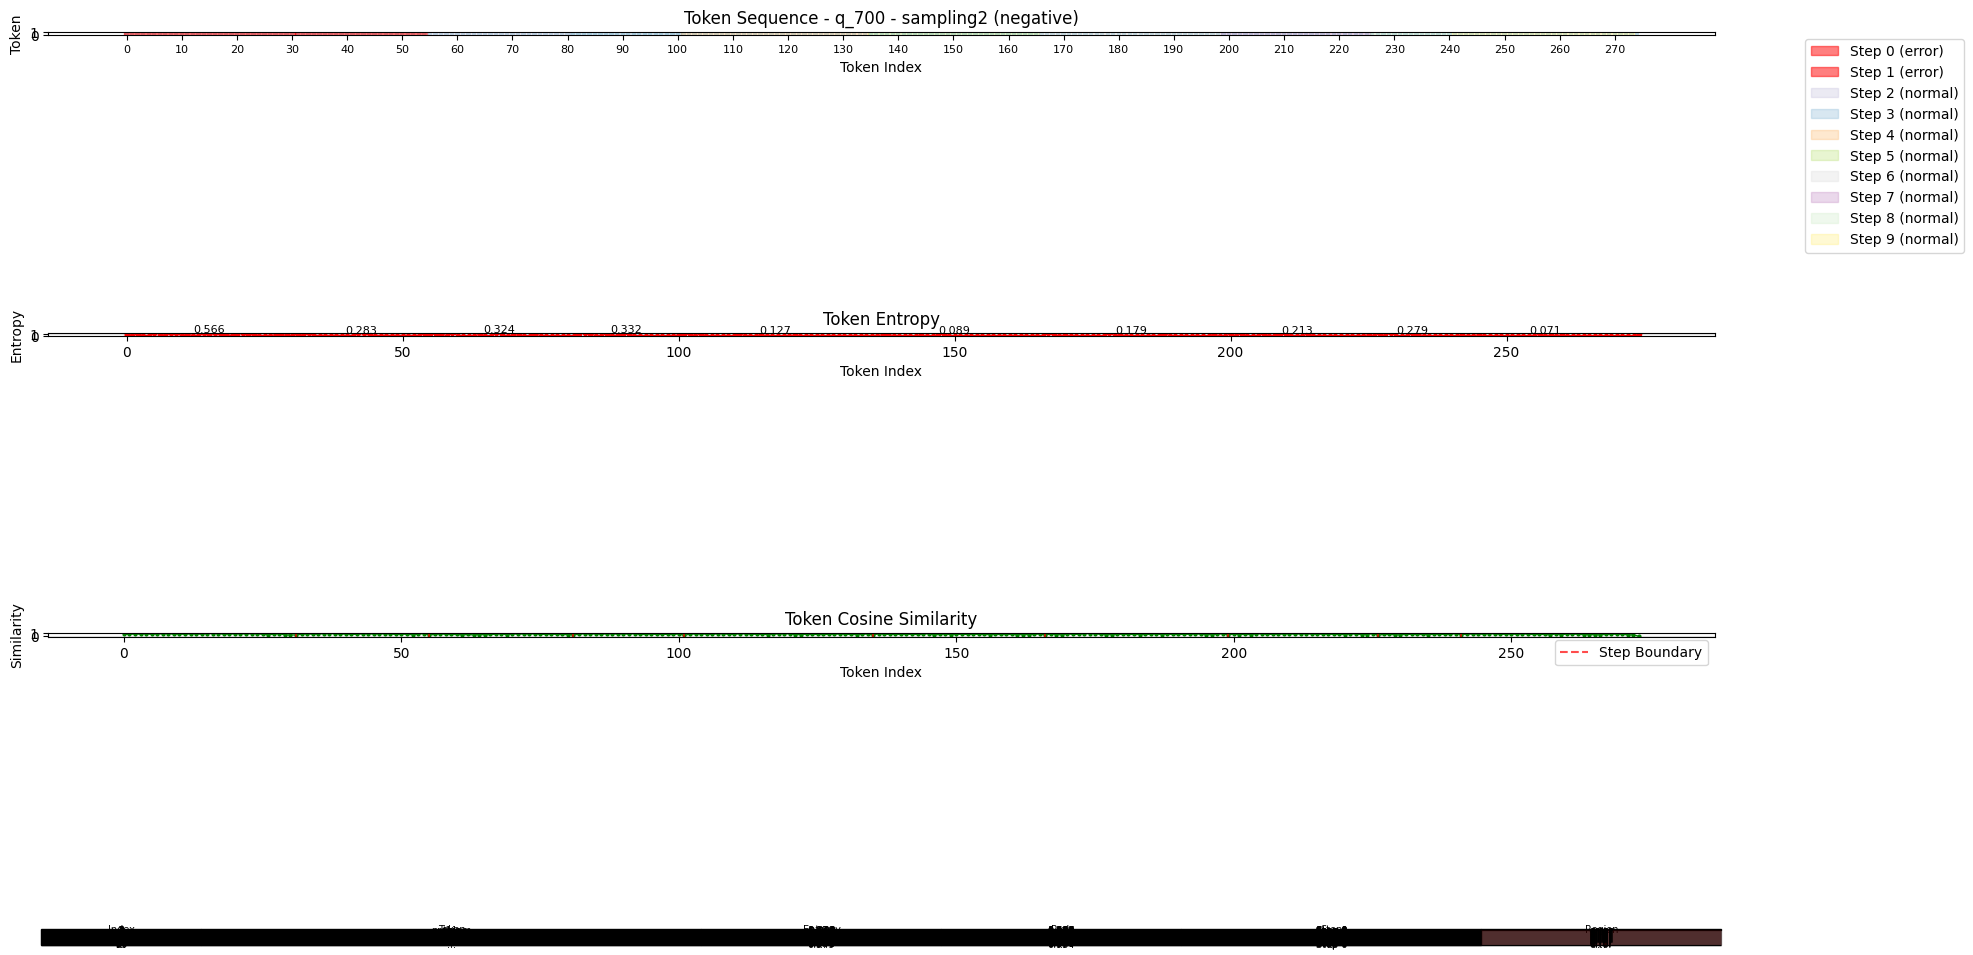


📊 STEP ANALYSIS: q_700 - sampling2
📋 Sample Type: negative
📋 Total Steps: 10
📋 Total Tokens: 275
Step 0: Token 0--30 🔴 ERROR
  Content: In this problem , we can set up a simple equation to represent the cost of a single brown sock and the cost of two white socks .   Let
  Average Entropy: 0.566
  Token Count: 31

Step 1: Token 31--54 🔴 ERROR
  Content: ' s denote the cost of a single brown sock as B , and the cost of two white socks as W . 
  Average Entropy: 0.283
  Token Count: 24

Step 2: Token 55--80
  Content:  We know that W = B +  2 5 cents .   We also know that two white socks cost  4 5
  Average Entropy: 0.324
  Token Count: 26

Step 3: Token 81--100
  Content: cents . So , we can set up the equation :   W =  4 5 cents 
  Average Entropy: 0.332
  Token Count: 20

Step 4: Token 101--134
  Content:  Substituting the value of W from the first equation into the second equation , we get :   ( B +  2 5 cents ) =  4 5 cents 
  Average Entropy: 0.127
  Token Count: 34

Step 5: Token 

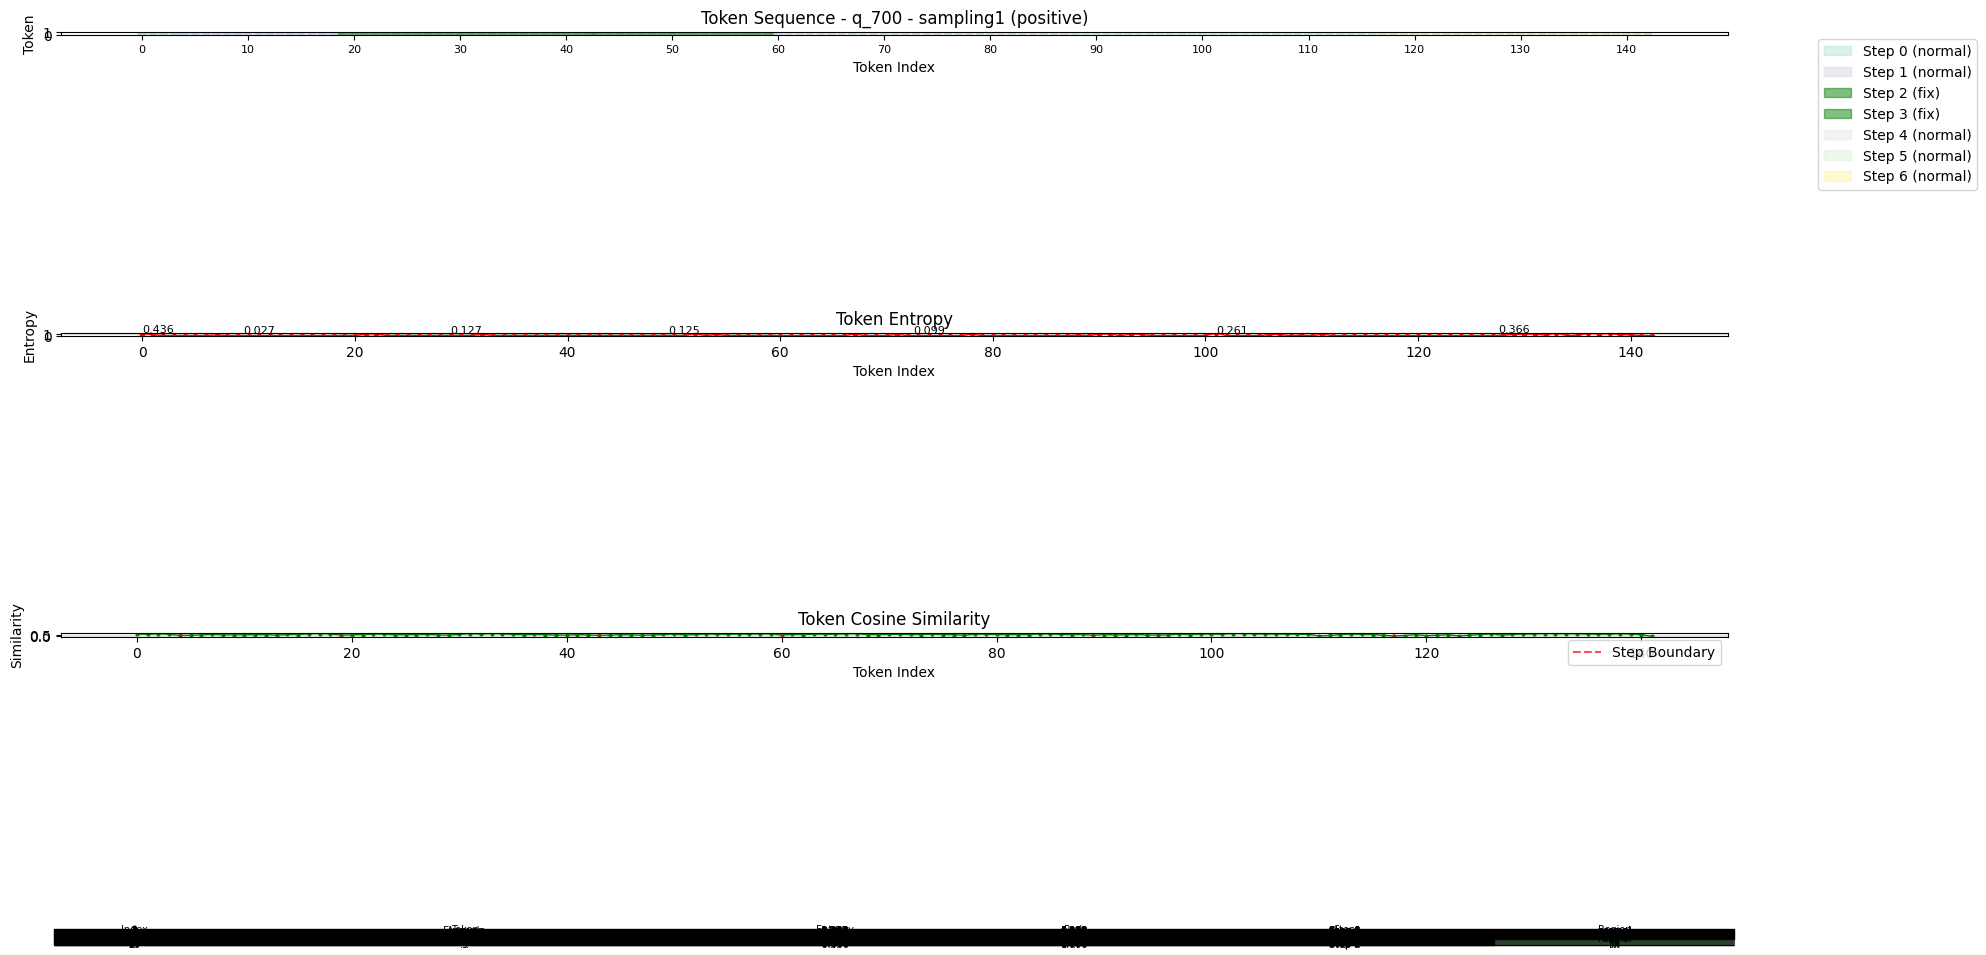


📊 STEP ANALYSIS: q_700 - sampling1
📋 Sample Type: positive
📋 Total Steps: 7
📋 Total Tokens: 143
Step 0: Token 0--3
  Content: Example Answer : 
  Average Entropy: 0.436
  Token Count: 4
  Token Details:
    [0] 'Example' (entropy: 1.158)
    [1] 'Answer' (entropy: 0.587)
    [2] ':' (entropy: -0.000)
    [3] '' (entropy: -0.000)

Step 1: Token 4--18
  Content: < steps > Two white socks cost  2 5 cents more than a single
  Average Entropy: 0.027
  Token Count: 15

Step 2: Token 19--42 🟢 FIX
  Content: brown sock . If two white socks cost  4 5 cents , then a single brown sock costs  4 5 - 
  Average Entropy: 0.127
  Token Count: 24

Step 3: Token 43--59 🟢 FIX
  Content: 2 5 =  2 0 cents .  To find the cost of  1 5
  Average Entropy: 0.125
  Token Count: 17

Step 4: Token 60--88
  Content: brown socks , multiply the cost of one brown sock by  1 5 :  2 0 *  1 5 =  3 0 0 cents .
  Average Entropy: 0.099
  Token Count: 29

Step 5: Token 89--116
  Content:  Since  1 dollar equals  1 0 0 cent

In [36]:
class StepTokenMapper:
    """将step的index映射到token上，并进行可视化"""

    def __init__(self, error_fix_data: Dict[str, Any], original_data: Dict[str, Any]):
        self.error_fix_data = error_fix_data
        self.original_data = original_data
        # 添加步骤分割结果缓存
        self.step_cache = {}

        print(f"📊 StepTokenMapper initialized with:")
        print(f"  - Error fix data: {len(error_fix_data)} samples")
        print(f"  - Original data: {len(original_data)} samples")

    def compute_token_similarities(self, token_level: List[Dict]) -> List[float]:
        """计算token之间的cosine similarity"""
        vectors = [entry["hidden_vector"] for entry in token_level if "hidden_vector" in entry]
        if len(vectors) < 2:
            return []

        similarities = []
        for i in range(len(vectors) - 1):
            sim = cosine_similarity([vectors[i]], [vectors[i + 1]])[0][0]
            similarities.append(sim)

        return similarities

    def find_steps(self, similarities: List[float], distance: int = 8, prominence: float = 0.5) -> List[int]:
        """基于similarity valleys找到step boundaries"""
        if not similarities:
            return [0]

        peaks, _ = find_peaks(-np.array(similarities), distance=distance, prominence=prominence)
        steps = [0] + peaks.tolist() + [len(similarities)]
        return sorted(list(set(steps)))

    def map_token_range_to_steps(self, similarities: List[float], start_idx: int, end_idx: int,
                                steps: List[int]) -> set:
        """将token范围映射到对应的step集合"""
        if start_idx is None or end_idx is None or start_idx == -1 or end_idx == -1:
            return set()

        affected_steps = set()
        for i in range(len(steps) - 1):
            step_start, step_end = steps[i], steps[i+1]
            if not (end_idx < step_start or start_idx >= step_end):
                affected_steps.add(i)
        return affected_steps

    def extract_and_cache_step_boundaries(self, qid: str, sampling_id: str, token_probs: List[Dict],
                                         distance: int = 15, prominence: float = 0.3) -> List[Dict[str, Any]]:
        """提取并缓存步骤边界"""
        cache_key = f"{qid}_{sampling_id}"

        # 检查缓存
        if cache_key in self.step_cache:
            print(f"  📋 Using cached steps for {cache_key}")
            return self.step_cache[cache_key]['steps']

        print(f"  🔍 Computing step boundaries for {cache_key}")

        if not token_probs or len(token_probs) < 2:
            return []

        similarities = self.compute_token_similarities(token_probs)
        if not similarities:
            return []

        step_boundaries = self.find_steps(similarities, distance=distance, prominence=prominence)

        steps = []
        for i in range(len(step_boundaries) - 1):
            step_start = step_boundaries[i]
            step_end = step_boundaries[i + 1]

            # 提取step内容（完整的token序列）
            step_tokens = []
            step_token_details = []
            for j in range(step_start, min(step_end, len(token_probs))):
                token_text = token_probs[j].get('token', '')
                step_tokens.append(token_text)
                step_token_details.append({
                    'token_index': j,
                    'token': token_text,
                    'entropy': token_probs[j].get('topk_info', {}).get('entropy', 0.0),
                    'chosen_prob': token_probs[j].get('chosen_prob', 0.0)
                })

            step_content = ' '.join(step_tokens)

            # 计算平均entropy
            entropies = [detail['entropy'] for detail in step_token_details]
            step_entropy = np.mean(entropies) if entropies else 0.0

            # 计算实际的token范围
            actual_token_start = step_start if step_start < len(token_probs) else -1
            actual_token_end = min(step_end - 1, len(token_probs) - 1) if step_end > step_start else -1

            steps.append({
                'step_id': i,
                'content': step_content,
                'token_start': actual_token_start,
                'token_end': actual_token_end,
                'entropies': entropies,
                'step_entropy': step_entropy,
                'token_count': len(step_token_details),
                'similarities': similarities[step_start:step_end-1] if step_start < len(similarities) else [],
                'token_details': step_token_details,
                'raw_boundaries': (step_start, step_end)
            })

        # 缓存结果
        self.step_cache[cache_key] = {
            'steps': steps,
            'similarities': similarities,
            'step_boundaries': step_boundaries,
            'token_count': len(token_probs)
        }

        print(f"  ✅ Cached {len(steps)} steps for {cache_key}")
        return steps

    def get_cached_step_info(self, qid: str, sampling_id: str) -> Dict[str, Any]:
        """获取缓存的步骤信息"""
        cache_key = f"{qid}_{sampling_id}"
        return self.step_cache.get(cache_key, {})

    def process_sample_data(self, qid: str) -> Dict[str, Any]:
        """处理单个样本的数据"""
        if qid not in self.error_fix_data or qid not in self.original_data:
            print(f"❌ Sample {qid} not found in data")
            return None

        error_fix_info = self.error_fix_data[qid]
        original_info = self.original_data[qid]

        result = {
            'qid': qid,
            'question': original_info.get('question', ''),
            'samples': {}
        }

        print(f"🔍 Processing sample {qid}")

        # 处理负样本（包含错误）
        for sampling_id, error_info in error_fix_info.items():
            if sampling_id.startswith('sampling') and sampling_id in original_info:
                print(f"  📝 Processing negative sample: {sampling_id}")

                sampling_data = original_info[sampling_id]
                whole_answer = sampling_data.get('whole_answer', '')
                token_probs = sampling_data.get('token_probs', [])

                # 提取并缓存步骤边界
                steps = self.extract_and_cache_step_boundaries(qid, sampling_id, token_probs)
                cached_info = self.get_cached_step_info(qid, sampling_id)

                correct_sampling_id = error_info.get('correct_sampling_id', '')
                similarities = cached_info.get('similarities', [])
                step_boundaries = cached_info.get('step_boundaries', [0])

                error_start = error_info.get('error_token_begin_index', -1)
                error_end = error_info.get('error_token_end_index', -1)
                error_steps = self.map_token_range_to_steps(similarities, error_start, error_end, step_boundaries)

                # 为每个step添加区域标记
                for step in steps:
                    step['is_error_step'] = step['step_id'] in error_steps
                    step['is_fix_step'] = False
                    step['region_type'] = 'error' if step['step_id'] in error_steps else 'normal'

                result['samples'][sampling_id] = {
                    'whole_answer': whole_answer,
                    'token_probs': token_probs,
                    'error_info': error_info,
                    'step_token_mapping': steps,
                    'similarities': similarities,
                    'step_boundaries': step_boundaries,
                    'error_token_range': (error_start, error_end),
                    'fix_token_range': (-1, -1),
                    'error_steps': list(error_steps),
                    'fix_steps': [],
                    'sample_type': 'negative',
                    'correct_sampling_id': correct_sampling_id
                }

        # 处理正样本（包含修复）
        for sampling_id, error_info in error_fix_info.items():
            if sampling_id.startswith('sampling'):
                correct_sampling_id = error_info.get('correct_sampling_id', '')

                if correct_sampling_id and correct_sampling_id in original_info:
                    if correct_sampling_id not in result['samples']:
                        print(f"  📝 Processing positive sample: {correct_sampling_id}")

                        positive_data = original_info[correct_sampling_id]
                        positive_answer = positive_data.get('whole_answer', '')
                        positive_token_probs = positive_data.get('token_probs', [])

                        # 提取并缓存步骤边界
                        positive_steps = self.extract_and_cache_step_boundaries(qid, correct_sampling_id, positive_token_probs)
                        positive_cached_info = self.get_cached_step_info(qid, correct_sampling_id)

                        positive_similarities = positive_cached_info.get('similarities', [])
                        positive_step_boundaries = positive_cached_info.get('step_boundaries', [0])

                        fix_start = error_info.get('fix_token_begin_index', -1)
                        fix_end = error_info.get('fix_token_end_index', -1)
                        fix_steps = self.map_token_range_to_steps(positive_similarities, fix_start, fix_end, positive_step_boundaries)

                        # 为每个step添加区域标记
                        for step in positive_steps:
                            step['is_error_step'] = False
                            step['is_fix_step'] = step['step_id'] in fix_steps
                            step['region_type'] = 'fix' if step['step_id'] in fix_steps else 'normal'

                        result['samples'][correct_sampling_id] = {
                            'whole_answer': positive_answer,
                            'token_probs': positive_token_probs,
                            'error_info': {},
                            'step_token_mapping': positive_steps,
                            'similarities': positive_similarities,
                            'step_boundaries': positive_step_boundaries,
                            'error_token_range': (-1, -1),
                            'fix_token_range': (fix_start, fix_end),
                            'error_steps': [],
                            'fix_steps': list(fix_steps),
                            'sample_type': 'positive',
                            'negative_sampling_id': sampling_id
                        }

        print(f"✅ Completed processing {qid}")
        return result

    def print_step_analysis(self, sample_data: Dict[str, Any], sampling_id: str, max_content_length: int = 5000):
        """打印详细的步骤分析"""
        if sampling_id not in sample_data['samples']:
            print(f"❌ Sampling {sampling_id} not found")
            return

        sample_info = sample_data['samples'][sampling_id]
        step_mapping = sample_info['step_token_mapping']

        print(f"\n{'='*80}")
        print(f"📊 STEP ANALYSIS: {sample_data['qid']} - {sampling_id}")
        print(f"📋 Sample Type: {sample_info.get('sample_type', 'unknown')}")
        print(f"📋 Total Steps: {len(step_mapping)}")
        print(f"📋 Total Tokens: {len(sample_info['token_probs'])}")
        print(f"{'='*80}")

        for step in step_mapping:
            region_marker = ""
            if step.get('region_type') == 'error':
                region_marker = " 🔴 ERROR"
            elif step.get('region_type') == 'fix':
                region_marker = " 🟢 FIX"

            content_preview = step['content']
            if len(content_preview) > max_content_length:
                content_preview = content_preview[:max_content_length] + "..."

            print(f"Step {step['step_id']}: Token {step['token_start']}--{step['token_end']}{region_marker}")
            print(f"  Content: {content_preview}")
            print(f"  Average Entropy: {step['step_entropy']:.3f}")
            print(f"  Token Count: {step.get('token_count', 0)}")

            # 显示token详情（如果有的话）
            if 'token_details' in step and len(step['token_details']) <= 10:  # 只显示短步骤的详情
                print(f"  Token Details:")
                for detail in step['token_details']:
                    print(f"    [{detail['token_index']}] '{detail['token']}' (entropy: {detail['entropy']:.3f})")

            print()

    def visualize_sample(self, sample_data: Dict[str, Any], sampling_id: str,
                        figsize: Tuple[int, int] = (20, 12)) -> None:
        """可视化单个样本的token和step映射"""
        if sampling_id not in sample_data['samples']:
            print(f"Sampling {sampling_id} not found in sample data")
            return

        sample_info = sample_data['samples'][sampling_id]
        token_probs = sample_info['token_probs']
        step_mapping = sample_info['step_token_mapping']
        similarities = sample_info.get('similarities', [])

        if not token_probs:
            print("No token probabilities found")
            return

        tokens = [entry.get('token', '') for entry in token_probs]
        entropies = [entry.get('topk_info', {}).get('entropy', 0.0) for entry in token_probs]
        probs = [entry.get('chosen_prob', 0.0) for entry in token_probs]

        fig, (ax1, ax2, ax3, ax4) = plt.subplots(4, 1, figsize=figsize, height_ratios=[1, 1, 1, 2])

        # Token序列和step区域
        token_positions = np.arange(len(tokens))
        ax1.bar(token_positions, [1] * len(tokens), color='lightblue', alpha=0.7)

        colors = plt.cm.Set3(np.linspace(0, 1, len(step_mapping)))
        for i, step in enumerate(step_mapping):
            if step['token_start'] != -1 and step['token_end'] != -1:
                start_idx = step['token_start']
                end_idx = step['token_end']

                if step.get('region_type') == 'error':
                    color = 'red'
                    alpha = 0.5
                elif step.get('region_type') == 'fix':
                    color = 'green'
                    alpha = 0.5
                else:
                    color = colors[i % len(colors)]
                    alpha = 0.3

                ax1.axvspan(start_idx - 0.5, end_idx + 0.5, alpha=alpha,
                           color=color, label=f"Step {step['step_id']} ({step.get('region_type', 'normal')})")

        ax1.set_title(f'Token Sequence - {sample_data["qid"]} - {sampling_id} ({sample_info.get("sample_type", "unknown")})')
        ax1.set_xlabel('Token Index')
        ax1.set_ylabel('Token')
        ax1.legend(bbox_to_anchor=(1.05, 1), loc='upper left')

        # 设置token标签
        if len(tokens) <= 50:
            ax1.set_xticks(token_positions[::2])
            ax1.set_xticklabels([f"{i}" for i in token_positions[::2]], fontsize=8)
        else:
            ax1.set_xticks(token_positions[::10])
            ax1.set_xticklabels([f"{i}" for i in token_positions[::10]], fontsize=8)

        # Entropy
        ax2.plot(token_positions, entropies, 'ro-', markersize=3, linewidth=1)
        ax2.set_title('Token Entropy')
        ax2.set_xlabel('Token Index')
        ax2.set_ylabel('Entropy')
        ax2.grid(True, alpha=0.3)

        # 标记step区域的平均entropy
        for i, step in enumerate(step_mapping):
            if step['token_start'] != -1 and step['token_end'] != -1:
                start_idx = step['token_start']
                end_idx = step['token_end']

                if step.get('region_type') == 'error':
                    color = 'red'
                    alpha = 0.3
                elif step.get('region_type') == 'fix':
                    color = 'green'
                    alpha = 0.3
                else:
                    color = colors[i % len(colors)]
                    alpha = 0.2

                ax2.axvspan(start_idx - 0.5, end_idx + 0.5, alpha=alpha, color=color)
                # 标注step的平均entropy
                mid_point = (start_idx + end_idx) / 2
                ax2.text(mid_point, step['step_entropy'], f"{step['step_entropy']:.3f}",
                        ha='center', va='bottom', fontsize=8)

        # 相似性
        if similarities:
            sim_positions = np.arange(len(similarities))
            ax3.plot(sim_positions, similarities, 'go-', markersize=2, linewidth=1)
            ax3.set_title('Token Cosine Similarity')
            ax3.set_xlabel('Token Index')
            ax3.set_ylabel('Similarity')
            ax3.grid(True, alpha=0.3)

            step_boundaries = sample_info.get('step_boundaries', [])
            for j, boundary in enumerate(step_boundaries[1:-1]):
                if boundary < len(similarities):
                    ax3.axvline(x=boundary, color='red', linestyle='--', alpha=0.7,
                               label='Step Boundary' if j == 0 else "")

            if len(step_boundaries) > 2:
                ax3.legend()

        # 详细信息表格
        ax4.axis('off')

        table_data = []
        display_limit = min(30, len(tokens))  # 最多显示30个token

        for i in range(display_limit):
            token = tokens[i]
            entropy = entropies[i]
            prob = probs[i]

            step_info = "None"
            region_type = "normal"
            for step in step_mapping:
                if (step['token_start'] != -1 and step['token_end'] != -1 and
                    step['token_start'] <= i <= step['token_end']):
                    step_info = f"Step {step['step_id']}"
                    region_type = step.get('region_type', 'normal')
                    break

            table_data.append([
                str(i),
                token[:15] + "..." if len(token) > 15 else token,
                f"{entropy:.3f}",
                f"{prob:.3f}",
                step_info,
                region_type
            ])

        if len(tokens) > display_limit:
            table_data.append(["...", "...", "...", "...", "...", "..."])

        table = ax4.table(cellText=table_data,
                         colLabels=['Index', 'Token', 'Entropy', 'Prob', 'Step', 'Region'],
                         cellLoc='center',
                         loc='center',
                         colWidths=[0.08, 0.25, 0.12, 0.12, 0.15, 0.12])

        table.auto_set_font_size(False)
        table.set_fontsize(7)
        table.scale(1.2, 1.5)

        # 为不同区域类型的token设置不同背景色
        for i, row in enumerate(table_data[:-1] if len(tokens) > display_limit else table_data):
            if len(row) > 5:
                region_type = row[5]
                if region_type == "error":
                    table[(i+1, 5)].set_facecolor('red')
                    table[(i+1, 5)].set_alpha(0.3)
                elif region_type == "fix":
                    table[(i+1, 5)].set_facecolor('green')
                    table[(i+1, 5)].set_alpha(0.3)

        plt.tight_layout()
        plt.show()

        # 打印详细的步骤分析
        self.print_step_analysis(sample_data, sampling_id)

    def clear_cache(self):
        """清空步骤缓存"""
        self.step_cache.clear()
        print("🗑️ Step cache cleared")

    def get_cache_info(self):
        """获取缓存信息"""
        print(f"📊 Cache Info:")
        print(f"  - Cached samples: {len(self.step_cache)}")
        for key, info in self.step_cache.items():
            print(f"  - {key}: {len(info['steps'])} steps, {info['token_count']} tokens")

# =============================================================================
# Cell 5: 创建映射器实例并快速测试
# =============================================================================

# 创建StepTokenMapper实例（使用已加载的数据）
mapper = StepTokenMapper(error_fix_data, original_data)

# 获取可用的问题ID
available_qids = list(mapper.error_fix_data.keys())
print(f"📊 Available question IDs: {len(available_qids)}")
print(f"📋 First 5 QIDs: {available_qids[:5]}")

# 快速测试一个样本
test_qid = available_qids[0]
print(f"\n🔍 Testing with sample: {test_qid}")

sample_data = mapper.process_sample_data(test_qid)
if sample_data:
    print(f"✅ Successfully processed {test_qid}")
    print(f"📊 Available samplings: {list(sample_data['samples'].keys())}")

    # 显示第一个sampling的基本信息
    first_sampling = list(sample_data['samples'].keys())[0]
    first_sample = sample_data['samples'][first_sampling]
    print(f"📋 Sample type: {first_sample.get('sample_type', 'unknown')}")
    print(f"📋 Steps count: {len(first_sample['step_token_mapping'])}")
    print(f"📋 Tokens count: {len(first_sample['token_probs'])}")

    # 显示缓存信息
    mapper.get_cache_info()
else:
    print(f"❌ Failed to process {test_qid}")

# =============================================================================
# Cell 6: 详细分析和可视化特定样本
# =============================================================================

# 选择一个样本进行详细分析
target_qid = available_qids[0]  # 可以修改这个索引来选择不同的样本
print(f"🎯 Analyzing sample: {target_qid}")

sample_data = mapper.process_sample_data(target_qid)
if sample_data:
    print(f"📊 Question: {sample_data['question'][:150]}...")
    print(f"📊 Available samplings: {list(sample_data['samples'].keys())}")

    # 可视化每个sampling
    for sampling_id in sample_data['samples'].keys():
        print(f"\n📈 Visualizing {sampling_id}...")
        mapper.visualize_sample(sample_data, sampling_id)

        # 显示步骤统计
        sample_info = sample_data['samples'][sampling_id]
        error_steps = len([s for s in sample_info['step_token_mapping'] if s.get('region_type') == 'error'])
        fix_steps = len([s for s in sample_info['step_token_mapping'] if s.get('region_type') == 'fix'])
        normal_steps = len([s for s in sample_info['step_token_mapping'] if s.get('region_type') == 'normal'])

        print(f"📊 Step statistics:")
        print(f"  - Error steps: {error_steps}")
        print(f"  - Fix steps: {fix_steps}")
        print(f"  - Normal steps: {normal_steps}")
        print(f"  - Total steps: {len(sample_info['step_token_mapping'])}")

# =============================================================================
# Cell 7: 批量处理多个样本
# =============================================================================

def batch_process_samples(mapper, qids, max_samples=5):
    """批量处理样本"""
    processed_results = {}

    print(f"🚀 Starting batch processing of {min(max_samples, len(qids))} samples...")

    for i, qid in enumerate(qids[:max_samples]):
        print(f"\n[{i+1}/{min(max_samples, len(qids))}] Processing {qid}...")

        sample_data = mapper.process_sample_data(qid)
        if sample_data:
            processed_results[qid] = sample_data

            # 统计信息
            total_steps = 0
            error_steps = 0
            fix_steps = 0

            for sampling_id, sample_info in sample_data['samples'].items():
                steps = sample_info['step_token_mapping']
                total_steps += len(steps)
                error_steps += len([s for s in steps if s.get('region_type') == 'error'])
                fix_steps += len([s for s in steps if s.get('region_type') == 'fix'])

            print(f"  ✅ Total steps: {total_steps}, Error: {error_steps}, Fix: {fix_steps}")
        else:
            print(f"  ❌ Failed to process {qid}")

    # 显示最终缓存信息
    print(f"\n📊 Final cache status:")
    mapper.get_cache_info()

    return processed_results

# 处理前5个样本
print("🚀 Starting batch processing...")
results = batch_process_samples(mapper, available_qids, max_samples=3)

print(f"\n📊 Batch processing complete!")
print(f"📋 Successfully processed: {len(results)} samples")

# =============================================================================
# Cell 8: 保存结果和详细分析
# =============================================================================

# 保存处理结果
if results:
    output_file = f"{paths['save_path']}/colab_processing_results_detailed.json"
    with open(output_file, 'w', encoding='utf-8') as f:
        json.dump(results, f, indent=2, ensure_ascii=False)

    print(f"💾 Results saved to: {output_file}")
    print(f"📂 Save directory: {paths['save_path']}")

    # 创建详细的统计报告
    total_samples = len(results)
    total_error_steps = 0
    total_fix_steps = 0
    total_normal_steps = 0
    total_tokens = 0

    print(f"\n📊 DETAILED PROCESSING REPORT")
    print(f"{'='*60}")

    for qid, sample_data in results.items():
        print(f"\n🔍 Sample: {qid}")
        print(f"📋 Question: {sample_data['question'][:100]}...")

        for sampling_id, sample_info in sample_data['samples'].items():
            steps = sample_info['step_token_mapping']
            error_count = len([s for s in steps if s.get('region_type') == 'error'])
            fix_count = len([s for s in steps if s.get('region_type') == 'fix'])
            normal_count = len([s for s in steps if s.get('region_type') == 'normal'])
            token_count = len(sample_info['token_probs'])

            total_error_steps += error_count
            total_fix_steps += fix_count
            total_normal_steps += normal_count
            total_tokens += token_count

            print(f"  📝 {sampling_id} ({sample_info.get('sample_type', 'unknown')}):")
            print(f"    - Steps: {len(steps)} (Error: {error_count}, Fix: {fix_count}, Normal: {normal_count})")
            print(f"    - Tokens: {token_count}")

    print(f"\n📊 FINAL STATISTICS:")
    print(f"{'='*60}")
    print(f"  - Total samples processed: {total_samples}")
    print(f"  - Total tokens: {total_tokens}")
    print(f"  - Total steps: {total_error_steps + total_fix_steps + total_normal_steps}")
    print(f"  - Error steps: {total_error_steps}")
    print(f"  - Fix steps: {total_fix_steps}")
    print(f"  - Normal steps: {total_normal_steps}")
    print(f"  - Average tokens per sample: {total_tokens / total_samples:.1f}")
    print(f"  - Average steps per sample: {(total_error_steps + total_fix_steps + total_normal_steps) / total_samples:.1f}")

print("\n🎉 Colab processing complete!")
print("💡 Tips:")
print("  - Data is loaded in memory and can be reused")
print("  - Step boundaries are cached for faster reprocessing")
print("  - Modify target_qid in Cell 6 to analyze different samples")
print("  - Adjust max_samples in Cell 7 to process more samples")
print("  - Results are saved and can be loaded later")
print("  - Use mapper.print_step_analysis(sample_data, sampling_id) for detailed step info")
print("  - Use mapper.clear_cache() to clear step cache if needed")

# =============================================================================
# Cell 9: 专门用于查看特定样本的详细步骤分析
# =============================================================================

def analyze_specific_sample(qid, sampling_id=None, show_visualization=True, show_step_details=True):
    """
    分析特定样本的详细信息

    Args:
        qid: 问题ID
        sampling_id: 采样ID，如果为None则分析所有采样
        show_visualization: 是否显示可视化
        show_step_details: 是否显示详细步骤信息
    """
    print(f"🎯 Analyzing specific sample: {qid}")

    sample_data = mapper.process_sample_data(qid)
    if not sample_data:
        print(f"❌ Failed to process sample {qid}")
        return

    available_samplings = list(sample_data['samples'].keys())
    print(f"📊 Available samplings: {available_samplings}")

    # 如果没有指定sampling_id，则分析所有
    target_samplings = [sampling_id] if sampling_id else available_samplings

    for target_sampling in target_samplings:
        if target_sampling not in available_samplings:
            print(f"❌ Sampling {target_sampling} not found")
            continue

        print(f"\n{'🔍 ANALYZING'} {target_sampling}")

        if show_step_details:
            # 显示详细的步骤分析
            mapper.print_step_analysis(sample_data, target_sampling, max_content_length=5000)

        if show_visualization:
            # 显示可视化
            mapper.visualize_sample(sample_data, target_sampling)

# 使用示例：分析特定样本
target_qid = available_qids[0]  # 修改这里选择不同的样本
print("🚀 Detailed analysis of specific sample:")

# 分析特定样本的所有采样
analyze_specific_sample(target_qid, show_visualization=True, show_step_details=True)

# 或者只分析特定的采样
# analyze_specific_sample(target_qid, sampling_id='sampling0', show_visualization=True, show_step_details=True)

# =============================================================================
# Cell 10: 步骤对比分析
# =============================================================================

def compare_error_fix_steps(qid):
    """
    对比错误步骤和修复步骤

    Args:
        qid: 问题ID
    """
    print(f"🔄 Comparing error and fix steps for {qid}")

    sample_data = mapper.process_sample_data(qid)
    if not sample_data:
        print(f"❌ Failed to process sample {qid}")
        return

    error_samples = []
    fix_samples = []

    # 分类样本
    for sampling_id, sample_info in sample_data['samples'].items():
        if sample_info.get('sample_type') == 'negative':
            error_samples.append((sampling_id, sample_info))
        elif sample_info.get('sample_type') == 'positive':
            fix_samples.append((sampling_id, sample_info))

    print(f"📊 Found {len(error_samples)} error samples and {len(fix_samples)} fix samples")

    # 对比分析
    for error_sampling_id, error_info in error_samples:
        print(f"\n{'='*80}")
        print(f"🔴 ERROR SAMPLE: {error_sampling_id}")
        print(f"{'='*80}")

        error_steps = [s for s in error_info['step_token_mapping'] if s.get('region_type') == 'error']

        for step in error_steps:
            print(f"❌ Error Step {step['step_id']}: Token {step['token_start']}--{step['token_end']}")
            print(f"   Content: {step['content'][:100]}...")
            print(f"   Entropy: {step['step_entropy']:.3f}")
            print()

        # 寻找对应的修复样本
        correct_sampling_id = error_info.get('correct_sampling_id')
        if correct_sampling_id:
            for fix_sampling_id, fix_info in fix_samples:
                if fix_sampling_id == correct_sampling_id:
                    print(f"🟢 CORRESPONDING FIX SAMPLE: {fix_sampling_id}")
                    print(f"{'='*80}")

                    fix_steps = [s for s in fix_info['step_token_mapping'] if s.get('region_type') == 'fix']

                    for step in fix_steps:
                        print(f"✅ Fix Step {step['step_id']}: Token {step['token_start']}--{step['token_end']}")
                        print(f"   Content: {step['content']}")
                        print(f"   Entropy: {step['step_entropy']:.3f}")
                        print()
                    break

# 使用示例：对比错误和修复步骤
compare_error_fix_steps(available_qids[0])

# =============================================================================
# Cell 11: 缓存管理和性能优化
# =============================================================================

def cache_management():
    """缓存管理功能"""
    print("🗂️ Cache Management")
    print("="*50)

    # 显示当前缓存状态
    mapper.get_cache_info()

    # 计算缓存大小（估算）
    cache_size_mb = 0
    for key, info in mapper.step_cache.items():
        # 估算每个步骤的内存使用
        steps_size = len(info['steps']) * 1000  # 假设每个步骤1KB
        similarities_size = len(info.get('similarities', [])) * 8  # float64
        cache_size_mb += (steps_size + similarities_size) / (1024 * 1024)

    print(f"📊 Estimated cache size: {cache_size_mb:.2f} MB")

    return cache_size_mb

def preprocess_all_samples(max_samples=None):
    """
    预处理所有样本，构建完整的步骤缓存

    Args:
        max_samples: 最大处理样本数，None表示处理所有
    """
    print("🚀 Preprocessing all samples to build step cache...")

    target_qids = available_qids[:max_samples] if max_samples else available_qids

    for i, qid in enumerate(target_qids):
        print(f"[{i+1}/{len(target_qids)}] Preprocessing {qid}...")

        # 只处理步骤分割，不做完整分析
        if qid in mapper.original_data:
            original_info = mapper.original_data[qid]

            for sampling_id in original_info.keys():
                if sampling_id.startswith('sampling'):
                    token_probs = original_info[sampling_id].get('token_probs', [])
                    if token_probs:
                        # 这会自动缓存步骤分割结果
                        mapper.extract_and_cache_step_boundaries(qid, sampling_id, token_probs)

    print("✅ Preprocessing complete!")
    cache_management()

# 缓存管理示例
cache_size = cache_management()

# 如果需要，可以预处理更多样本
# preprocess_all_samples(max_samples=10)

# 清空缓存（如果需要释放内存）
# mapper.clear_cache()

# =============================================================================
# Cell 12: 导出和统计分析
# =============================================================================

def export_step_statistics(results, export_path=None):
    """
    导出步骤统计信息到CSV

    Args:
        results: 处理结果
        export_path: 导出路径
    """
    if export_path is None:
        export_path = f"{paths['save_path']}/step_statistics.csv"

    print(f"📊 Exporting step statistics to {export_path}")

    # 收集所有步骤数据
    step_data = []

    for qid, sample_data in results.items():
        for sampling_id, sample_info in sample_data['samples'].items():
            steps = sample_info['step_token_mapping']

            for step in steps:
                step_data.append({
                    'qid': qid,
                    'sampling_id': sampling_id,
                    'sample_type': sample_info.get('sample_type', 'unknown'),
                    'step_id': step['step_id'],
                    'token_start': step['token_start'],
                    'token_end': step['token_end'],
                    'token_count': step.get('token_count', 0),
                    'region_type': step.get('region_type', 'normal'),
                    'step_entropy': step['step_entropy'],
                    'content_length': len(step['content']),
                    'is_error_step': step.get('is_error_step', False),
                    'is_fix_step': step.get('is_fix_step', False)
                })

    # 创建DataFrame并保存
    df = pd.DataFrame(step_data)
    df.to_csv(export_path, index=False)

    print(f"✅ Exported {len(step_data)} step records")

    # 生成基本统计
    print(f"\n📊 Basic Statistics:")
    print(f"  - Total steps: {len(step_data)}")
    print(f"  - Error steps: {len(df[df['region_type'] == 'error'])}")
    print(f"  - Fix steps: {len(df[df['region_type'] == 'fix'])}")
    print(f"  - Normal steps: {len(df[df['region_type'] == 'normal'])}")

    # 按区域类型的平均统计
    region_stats = df.groupby('region_type').agg({
        'step_entropy': ['mean', 'std'],
        'token_count': ['mean', 'std'],
        'content_length': ['mean', 'std']
    }).round(3)

    print(f"\n📊 Statistics by Region Type:")
    print(region_stats)

    return df

def generate_summary_report():
    """生成总结报告"""
    print(f"\n{'='*80}")
    print(f"📋 FINAL SUMMARY REPORT")
    print(f"{'='*80}")

    # 处理统计
    if 'results' in globals() and results:
        print(f"✅ Successfully processed {len(results)} samples")

        # 导出统计
        df = export_step_statistics(results)

        # 缓存统计
        cache_size = cache_management()

        # 性能建议
        print(f"\n💡 Performance Tips:")
        print(f"  - Step boundaries are cached for faster reprocessing")
        print(f"  - Use mapper.print_step_analysis() for detailed step information")
        print(f"  - Use analyze_specific_sample() for focused analysis")
        print(f"  - Use compare_error_fix_steps() for error-fix comparison")
        print(f"  - Clear cache with mapper.clear_cache() if memory is limited")

        print(f"\n📁 Generated Files:")
        print(f"  - Processing results: {paths['save_path']}/colab_processing_results_detailed.json")
        print(f"  - Step statistics: {paths['save_path']}/step_statistics.csv")

    else:
        print(f"❌ No results available. Please run Cell 7 first.")

# 生成最终报告
generate_summary_report()

print(f"\n🎉 All analysis complete!")
print(f"💻 Your data is ready for further analysis!")
print(f"🔄 You can rerun any cell to analyze different samples or adjust parameters.")# =============================================================================


In [25]:
results['q_700'].keys()

dict_keys(['qid', 'question', 'samples'])

In [26]:
results['q_700']['samples'].keys()

dict_keys(['sampling0', 'sampling2', 'sampling1'])

In [28]:
results['q_700']['samples']['sampling0'].keys()

dict_keys(['whole_answer', 'token_probs', 'error_info', 'step_token_mapping', 'similarities', 'step_boundaries', 'error_token_range', 'fix_token_range', 'error_steps', 'fix_steps', 'sample_type', 'correct_sampling_id'])

In [32]:
results['q_700']['samples']['sampling0']['step_token_mapping'][0]

{'step_id': 0,
 'content': 'Twowhitesockscost25centsmorethanasinglebrownsock.Twowhitesockscost45cents.',
 'token_start': 0,
 'token_end': 26,
 'entropies': [1.1579692067387053,
  -0.0,
  -0.0,
  -0.0,
  -0.0,
  -0.0,
  -0.0,
  -0.0,
  -0.0,
  -0.0,
  -0.0,
  -0.0,
  -0.0,
  -0.0,
  0.8977939295475067,
  1.0351459008122175,
  1.0048670583061832,
  -0.0,
  -0.0,
  -0.0,
  -0.0,
  -0.0,
  -0.0,
  -0.0,
  0.9577884968468506,
  -0.0,
  1.4880493889278805],
 'step_entropy': np.float64(0.24228199930293867),
 'token_count': 27,
 'similarities': [np.float64(0.8691429679083431),
  np.float64(0.7802682642506952),
  np.float64(0.7804748512840903),
  np.float64(0.7425534156503587),
  np.float64(0.7359318066827776),
  np.float64(0.7992266697439898),
  np.float64(0.7084063329186229),
  np.float64(0.8548973995711648),
  np.float64(0.8438012599549335),
  np.float64(0.9017021256400968),
  np.float64(0.9300258746807313),
  np.float64(0.8770351075868869),
  np.float64(0.6465366625027518),
  np.float64(0.6

In [24]:
results['q_700'].keys()

dict_keys(['qid', 'question', 'samples'])